<a href="https://colab.research.google.com/github/GioAcosta1/Proyecto_Final_Cancer_de_Piel/blob/main/DETECCION_Y_CLASIFICACION_DE_CANCER_DE_PIEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Montaje de drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Ordenamiento de las imágenes**

In [ ]:
#Descomprimir base de datos de imágenes
import io
import zipfile
import os
import glob


!unzip "/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/classes.zip" -d "/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/classes"

In [ ]:
#Librerias a utilizar
import pandas as pd
import os
import shutil
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from PIL import Image

from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.metrics import confusion_matrix

In [ ]:
#Lectura de metadata

data_skin = pd.read_csv('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM10000_metadata.csv')


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


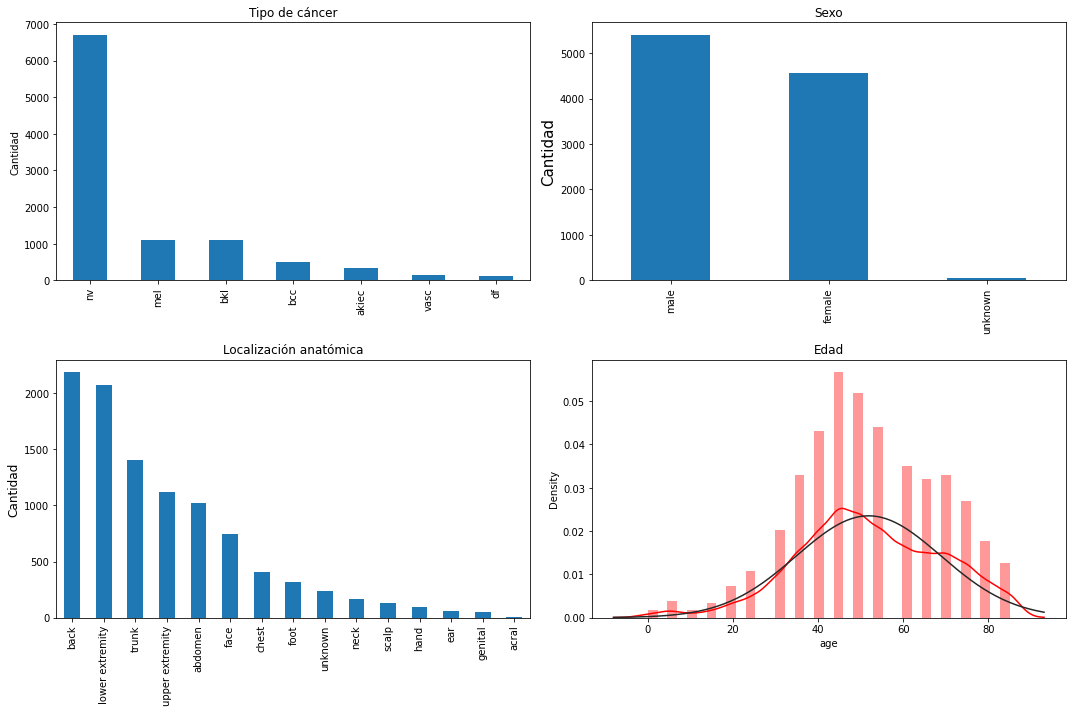

In [ ]:
#Ver la distribución de los datos
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
data_skin['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Cantidad')
ax1.set_title('Tipo de cáncer');

ax2 = fig.add_subplot(222)
data_skin['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Cantidad', size=15)
ax2.set_title('Sexo');

ax3 = fig.add_subplot(223)
data_skin['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Cantidad',size=12)
ax3.set_title('Localización anatómica')

ax4 = fig.add_subplot(224)
sample_age = data_skin[pd.notnull(data_skin['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Edad')

plt.tight_layout()
plt.show()

In [ ]:
#Etiquetado

l_encode = LabelEncoder()
l_encode.fit(data_skin['dx'])
LabelEncoder()
print(list(l_encode.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
data_skin['label'] = l_encode.transform(data_skin['dx'])
print(data_skin.sample(10))

        lesion_id      image_id     dx  ...     sex     localization label
3577  HAM_0002997  ISIC_0029972     nv  ...  female  upper extremity     5
9882  HAM_0000462  ISIC_0032897  akiec  ...  female  lower extremity     0
7985  HAM_0004172  ISIC_0034171     nv  ...    male             back     5
3051  HAM_0005487  ISIC_0031486     nv  ...    male  upper extremity     5
4979  HAM_0006841  ISIC_0026102     nv  ...  female  upper extremity     5
1745  HAM_0003495  ISIC_0032869    mel  ...    male             back     4
8115  HAM_0002907  ISIC_0029730     nv  ...    male            trunk     5
3529  HAM_0001591  ISIC_0032231     nv  ...  female  lower extremity     5
5694  HAM_0003211  ISIC_0029942     nv  ...  female  lower extremity     5
4310  HAM_0000359  ISIC_0025701     nv  ...  female  lower extremity     5

[10 rows x 8 columns]


In [ ]:
df_type_0 = data_skin[data_skin['dx']=='akiec']
df_type_1 = data_skin[data_skin['dx']=='bcc']
df_type_2 = data_skin[data_skin['dx']=='bkl']
df_type_3 = data_skin[data_skin['dx']=='df']
df_type_4 = data_skin[data_skin['dx']=='mel']
df_type_5 = data_skin[data_skin['dx']=='nv']
df_type_6 = data_skin[data_skin['dx']=='vasc']

len(df_type_2)

1099

In [ ]:
print(data_skin['dx'].value_counts())

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


In [ ]:
#Balancear base de datos

from sklearn.utils import resample

df_type_0_bal = resample(df_type_0, replace=True, n_samples = 400, random_state=42)
df_type_1_bal = resample(df_type_1, replace=True, n_samples = 400, random_state=42)
df_type_2_bal = resample(df_type_2, replace=True, n_samples = 400, random_state=42)
df_type_3_bal = resample(df_type_3, replace=True, n_samples = 400, random_state=42)
df_type_4_bal = resample(df_type_4, replace=True, n_samples = 400, random_state=42)
df_type_5_bal = resample(df_type_5, replace=True, n_samples = 400, random_state=42)
df_type_6_bal = resample(df_type_6, replace=True, n_samples = 400, random_state=42)

data_skin_bal = pd.concat([df_type_0_bal, df_type_1_bal, df_type_2_bal,
                           df_type_3_bal, df_type_4_bal, df_type_5_bal,
                           df_type_6_bal])

In [ ]:
import glob
image_path = glob.glob('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_ORGANIZED/classes/**/*.jpg')

In [ ]:
os.mkdir('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/akiec/')
os.mkdir('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/bcc/')
os.mkdir('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/bkl/')
os.mkdir('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/df/')
os.mkdir('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/mel/')
os.mkdir('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/nv/')
os.mkdir('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/vasc/')

In [ ]:
for id in data_skin_bal['image_id']:
  find_path = [s for s in image_path if id in s]
  for path in find_path:
    p = path.split('/')
    if 'akiec' in p:
      shutil.copy(path,'/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/akiec/')
    elif 'bcc' in p:
      shutil.copy(path,'/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/bcc/')
    elif 'bkl' in p:
      shutil.copy(path,'/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/bkl/')
    elif 'df' in p:
      shutil.copy(path,'/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/df/')
    elif 'mel' in p:
      shutil.copy(path,'/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/mel/')
    elif 'nv' in p:
      shutil.copy(path,'/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/nv/')
    elif 'vasc' in p:
      shutil.copy(path,'/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/vasc/') 



In [ ]:
arc_akiec = os.listdir('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM_TOTAL/bcc/')
len(arc_akiec)

271

# **Creación de Data Generator**

In [ ]:
data_generator = ImageDataGenerator(validation_split = 0.15)

In [ ]:
path_classes = '/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_ORGANIZED/classes/'
train_image_generator = data_generator.flow_from_directory(
    directory = path_classes,
    class_mode = 'categorical',
    batch_size = 16,
    target_size = (64,64),
    subset = 'training'
)
val_image_generator = data_generator.flow_from_directory(
    directory = path_classes,
    class_mode = 'categorical',
    batch_size = 16,
    target_size = (64, 64),
    subset = 'validation'
)

Found 8516 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


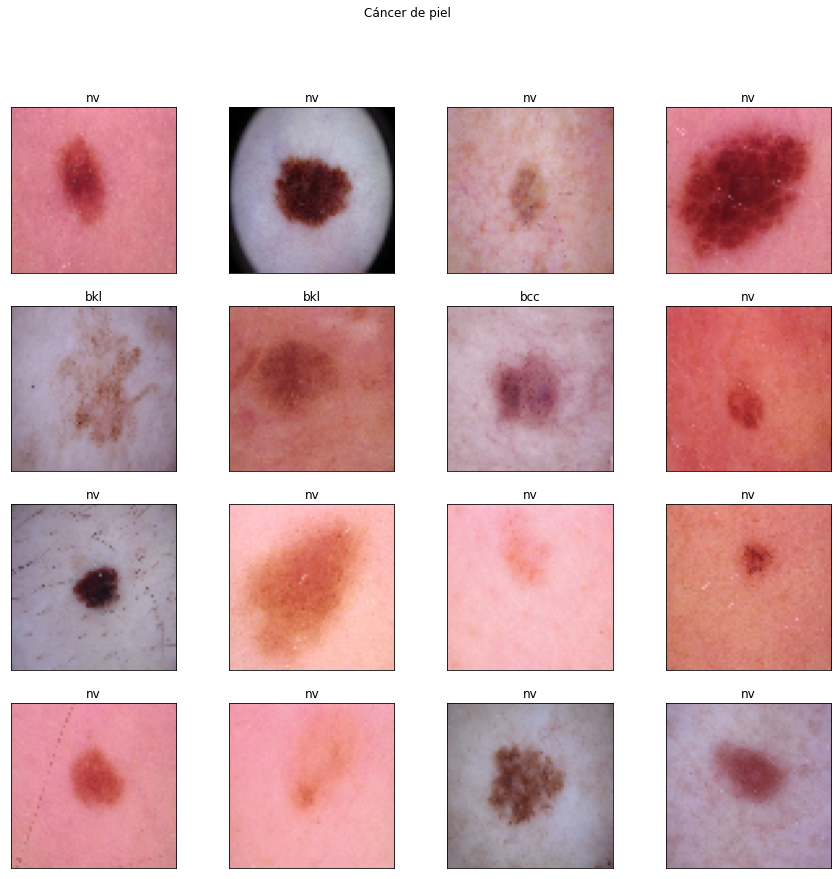

In [ ]:
x, y = next(train_image_generator)
classes = train_image_generator.class_indices
fig = plt.figure(figsize=(15,14))
fig.suptitle('Cáncer de piel')
for i in range(0, 16):
  plt.subplot(4,4,i+1)
  image = x[i].astype(int)
  y_search = y[i,:]
  idx = list(np.where(y_search==1))
  n_type = list(classes.keys())[list(classes.values()).index(idx[0])]
  fig.add_subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(n_type)
  plt.xticks([])
  plt.yticks([])
  n_type = ''

# **Definición de red neuronal convolucional**

In [ ]:
n_classes = 7

model = Sequential()
model.add(Conv2D(256, (3,3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPool2D(pool_size=(2,2,)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2,)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2,)))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation = 'softmax'))
model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['acc'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 62, 256)       7168      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 31, 31, 256)      0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 31, 31, 256)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 128)       295040    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 14, 14, 128)      

# **Entrenamiento de la red neuronal convolucional**

In [ ]:
num_epochs = 50
history = model.fit(
    train_image_generator,
    steps_per_epoch = train_image_generator.samples//train_image_generator.batch_size,
    validation_data = val_image_generator,
    validation_steps = val_image_generator.samples // val_image_generator.batch_size,
    epochs = num_epochs)

Epoch 1/50
532/532 [==============================] - 106s 198ms/step - loss: 2.5340 - acc: 0.6416 - val_loss: 1.0599 - val_acc: 0.6694
Epoch 2/50
532/532 [==============================] - 104s 195ms/step - loss: 1.0276 - acc: 0.6644 - val_loss: 0.9480 - val_acc: 0.6694
Epoch 3/50
532/532 [==============================] - 102s 192ms/step - loss: 0.9788 - acc: 0.6667 - val_loss: 0.9021 - val_acc: 0.6653
Epoch 4/50
532/532 [==============================] - 105s 196ms/step - loss: 0.9551 - acc: 0.6676 - val_loss: 0.8817 - val_acc: 0.6720
Epoch 5/50
532/532 [==============================] - 103s 193ms/step - loss: 0.9398 - acc: 0.6693 - val_loss: 0.9151 - val_acc: 0.6727
Epoch 6/50
532/532 [==============================] - 103s 193ms/step - loss: 0.9402 - acc: 0.6696 - val_loss: 0.8858 - val_acc: 0.6741
Epoch 7/50
532/532 [==============================] - 104s 196ms/step - loss: 0.9374 - acc: 0.6671 - val_loss: 0.8931 - val_acc: 0.6667
Epoch 8/50
532/532 [============================

KeyboardInterrupt: ignored

In [ ]:
#score = model.evaluate(x_test, y_test)
#print('Test accuracy:', score[1])

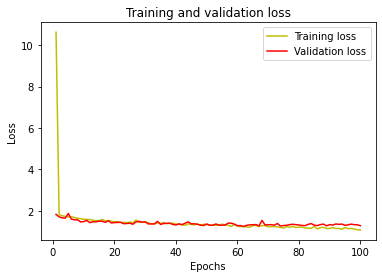

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

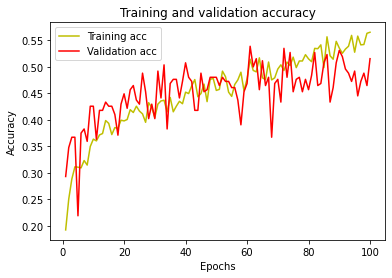

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
image_test = Image.open('/content/melanoma.jpg')
image_test_resize = image_test.resize((32,32))

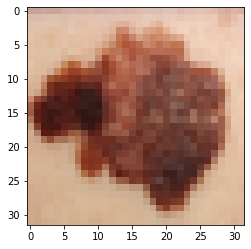

In [ ]:
plt.imshow(image_test_resize)

In [ ]:
image_test_resize = np.array(image_test_resize)
nn = image_test_resize.reshape(1,32,32,3)

pred = model.predict(nn)
print(pred)
pred_class = np.argmax(pred, axis=1)

1/1 [==============================] - 0s 24ms/step
[[1.7193703e-02 1.4434011e-03 5.2206405e-02 6.9435919e-04 7.5322223e-01
  1.7518704e-01 5.2806809e-05]]


4